# Project 3: Big graphs

The objective of this project is to use Spark’s APIs to analyze the flight interconnected data to predict the cancellation of flights.

## Task 1: Data Ingestion and Preparation

### Session Setup

In [1]:
import pyspark

# Prepare the Spark builder
spark = pyspark.sql.SparkSession.builder.appName("Project_4") \
    .config("spark.driver.memory", "6g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.memory", "6g") \
    .getOrCreate()

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.shuffle.partitions", 8)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 500)

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import *

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StringIndexer, OneHotEncoder, StringIndexerModel

import matplotlib.pyplot as plt
import pandas as pd

import shutil
import os

### Data Ingestion

In [3]:
schema = StructType([
    StructField("FL_DATE", DateType(), True),
    StructField("OP_CARRIER", StringType(), True),
    StructField("OP_CARRIER_FL_NUM", IntegerType(), True),
    StructField("ORIGIN", StringType(), True),
    StructField("DEST", StringType(), True),
    StructField("CRS_DEP_TIME", IntegerType(), True),
    StructField("DEP_TIME", DoubleType(), True),
    StructField("DEP_DELAY", DoubleType(), True),
    StructField("TAXI_OUT", DoubleType(), True),
    StructField("WHEELS_OFF", DoubleType(), True),
    StructField("WHEELS_ON", DoubleType(), True),
    StructField("TAXI_IN", DoubleType(), True),
    StructField("CRS_ARR_TIME", IntegerType(), True),
    StructField("ARR_TIME", DoubleType(), True),
    StructField("ARR_DELAY", DoubleType(), True),
    StructField("CANCELLED", DoubleType(), True),
    StructField("CANCELLATION_CODE", StringType(), True),
    StructField("DIVERTED", DoubleType(), True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), True),
    StructField("ACTUAL_ELAPSED_TIME", DoubleType(), True),
    StructField("AIR_TIME", DoubleType(), True),
    StructField("DISTANCE", DoubleType(), True),
    StructField("CARRIER_DELAY", DoubleType(), True),
    StructField("WEATHER_DELAY", DoubleType(), True),
    StructField("NAS_DELAY", DoubleType(), True),
    StructField("SECURITY_DELAY", DoubleType(), True),
    StructField("LATE_AIRCRAFT_DELAY", DoubleType(), True),
    StructField("Unnamed: 27", StringType(), True)
])

# Reading in the datasets
flight_df_csv = spark.read.csv("input/2009.csv", header=True, schema=schema)

### Partitioned Parquet

In [4]:
parquet_path = "output/parquet_data"
flight_df_csv.write.mode("overwrite").partitionBy("CANCELLED").parquet(parquet_path)

In [5]:
flight_df = spark.read.parquet(parquet_path)
flight_df.cache()
flight_df.printSchema()

root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: double (nullable = true)
 |-- NAS_DELAY: doub

## Task 2: Cleaning and Preprocessing 

### Renaming columns for consistency

In [6]:
renamed_columns = [
    "Date", "UniqueCarrier", "FlightNumber", "Origin", "Destination",
    "CRSDepTime", "DepartureTime", "DepartureDelay", "TaxiOut", "WheelsOff",
    "WheelsOn", "TaxiIn", "CRSArrivalTime", "ArrivalTime", "ArrivalDelay",
    "CancellationCode", "Diverted", "CRSElapsedTime",
    "ActualElapsedTime", "AirTime", "Distance", "CarrierDelay",
    "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay",
    "UnusedColumn", "Cancelled"
]

flight_df = flight_df.toDF(*renamed_columns)

### Filtering out diverted flights

In [7]:
flight_df = flight_df.filter(F.col("Diverted") != 1)
flight_df = flight_df.drop("Diverted")

### Balancing the dataframe

The flight dataframe is heavily unbalanced and this made the model very biased. We included the same amount of cancelled and departed flights in the training data.

In [8]:
cancelled_df = flight_df.filter(F.col("Cancelled") == 1)
departed_df = flight_df.filter(F.col("Cancelled") == 0)

cancelled_count = cancelled_df.count()
departed_count = departed_df.count()

# We slightly increased the ratio of departed fligths as original data is heavily unbalanced
# 50-50 distibution leads the model to become too sensitive
cancelled_ratio = 0.04 + cancelled_count / departed_count
print(f"{round(cancelled_ratio, 4)} of departed flights are used.")

sample = departed_df.sample(withReplacement=False, fraction=cancelled_ratio, seed=42)

flight_df = cancelled_df.union(sample)

0.0538 of departed flights are used.


### Creating day of week and month columns

In [9]:
flight_df = flight_df.withColumn("DayofWeek", F.dayofweek("Date")) \
                     .withColumn("Month", F.month("Date"))

### Handindling empty values

As the goal of the model is to predict flight cancellation, only attributes that relate to events which have happened before the departure/ cancellation can be used for predictions. Therefore, columns such as WheelsOff, ArrivalTime etc. are removed from the training data.

In [10]:
# Removing columns which have only NULL values for all cancelled fligths (events which occur after successful take-off)
# Including these would give an unfair advantage to the model
flight_df = flight_df.drop("UnusedColumn", "LateAircraftDelay", "SecurityDelay", "NASDelay", "WeatherDelay", "CarrierDelay", "AirTime", "ActualElapsedTime", "ArrivalDelay", "ArrivalTime", "TaxiIn", "WheelsOn")

In [11]:
# Data missing for most cancelled flights, therefore, dropping seems like the best option
flight_df = flight_df.drop("DepartureTime", "DepartureDelay", "TaxiOut", "WheelsOff")

### Creating Additional Features

In [12]:
# Creating a column for seasons
flight_df = flight_df.withColumn(
    "Season",
    F.when(F.col("Month").isin(12, 1, 2), 0)
    .when(F.col("Month").isin(3, 4, 5), 1)
    .when(F.col("Month").isin(6, 7, 8), 2)
    .when(F.col("Month").isin(9, 10, 11), 3)
    .otherwise(-1)
)

# Creating a column to differentiate weekends
flight_df = flight_df.withColumn("IsWeekend", F.when(F.col("DayofWeek").isin([6, 7]), 1).otherwise(0))

### Result of data cleaning and preprocessing

In [13]:
flight_df.describe().toPandas()

,summary,UniqueCarrier,FlightNumber,Origin,Destination,CRSDepTime,CRSArrivalTime,CancellationCode,CRSElapsedTime,Distance,Cancelled,DayofWeek,Month,Season,IsWeekend
0,count,427008,427008,427008,427008,427008,427008,87038,427008,427008,427008,427008,427008,427008,427008
1,mean,None,2413.9736773081536,None,None,1325.7582949265588,1500.2559928619605,None,126.17752594799161,693.1668750936751,0.2038322467026379,3.930333857913669,6.315094799160671,1.4152685663968825,0.266142554706235
2,stddev,None,2100.6460321936916,None,None,457.4588449398627,473.04547859550496,None,67.46788925237584,542.2623097659691,0.40284617654672944,1.9523989258723915,3.4263883129623203,1.0960199693713946,0.44194021391504096
3,min,9E,1,ABE,ABE,3,1,A,1.0,11.0,0.0,1,1,0,0
4,max,YV,7816,YUM,YUM,2359,2359,D,660.0,4962.0,1.0,7,12,3,1


## Task 3: Exporatory Analysis

### Top Carriers

In [14]:
# All flights
top_carriers = (
    flight_df.groupBy("UniqueCarrier")
           .agg(F.count("*").alias("Count"))
           .orderBy(F.desc("Count"))
           .limit(10)
)

top_carriers.show()

+-------------+-----+
|UniqueCarrier|Count|
+-------------+-----+
|           WN|68743|
|           AA|38067|
|           OO|36292|
|           MQ|33344|
|           DL|27374|
|           US|26916|
|           UA|26040|
|           EV|21967|
|           XE|21535|
|           9E|18504|
+-------------+-----+



In [15]:
# Cancelled fligths
top_carriers = (
    cancelled_df.groupBy("UniqueCarrier")
           .agg(F.count("*").alias("Count"))
           .orderBy(F.desc("Count"))
           .limit(10)
)

top_carriers.show()

+-------------+-----+
|UniqueCarrier|Count|
+-------------+-----+
|           MQ|10695|
|           AA| 9191|
|           WN| 8405|
|           OO| 7423|
|           EV| 6314|
|           UA| 6213|
|           XE| 5193|
|           OH| 5108|
|           US| 5047|
|           DL| 4799|
+-------------+-----+



### Cancellation Reasons

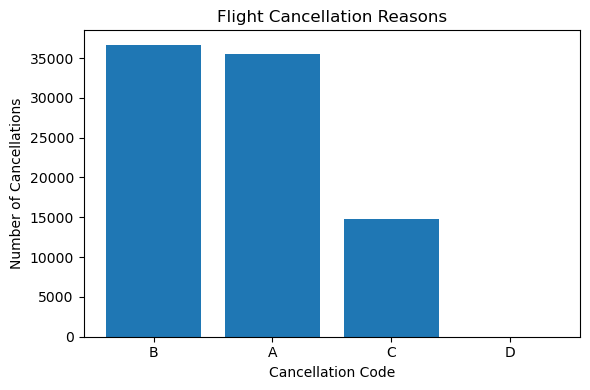

In [16]:
cancellation_codes = (
    cancelled_df.groupBy("CancellationCode")
           .agg(F.count("*").alias("Count"))
           .orderBy(F.desc("Count"))
)

cancellation_codes = cancellation_codes.select("CancellationCode", "Count").collect()

labels = [row["CancellationCode"] for row in cancellation_codes]
counts = [row["Count"] for row in cancellation_codes]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title("Flight Cancellation Reasons")
plt.ylabel("Number of Cancellations")
plt.xlabel("Cancellation Code")
plt.tight_layout()
plt.show()

### Class Distribution and Inbalance

The original class imbalance ratio was 0.01376 .
The class imbalance after balancing is 0.25602 .


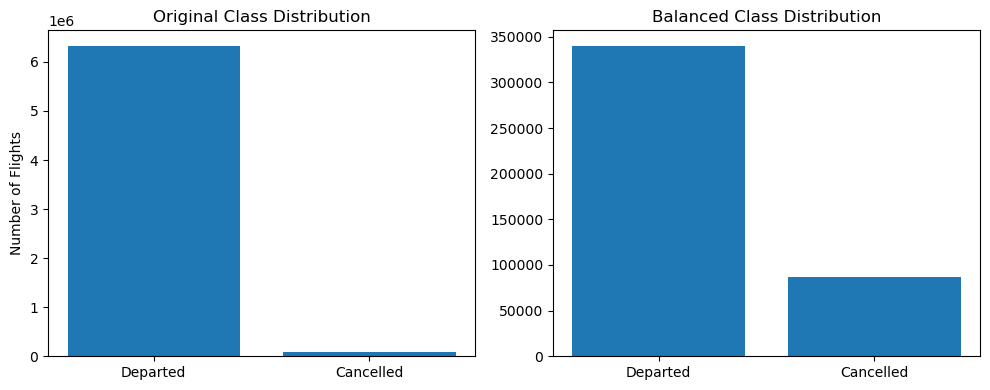

In [17]:
print(f"The original class imbalance ratio was {round(cancelled_ratio - 0.04, 5)} .")

departed_balanced = sample.count() # the sample taken from departed_df

cancelled_ratio = cancelled_count / departed_balanced
print(f"The class imbalance after balancing is {round(cancelled_ratio, 5)} .")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].bar(['Departed', 'Cancelled'], [departed_count, cancelled_count])
axes[0].set_title('Original Class Distribution')
axes[0].set_ylabel('Number of Flights')

axes[1].bar(['Departed', 'Cancelled'], [departed_balanced, cancelled_count])
axes[1].set_title('Balanced Class Distribution')

plt.tight_layout()
plt.show()

## Task 4: Feature Engineering

In [18]:
# Selected columns for the model
categorical_cols = ['Origin', 'Destination', "UniqueCarrier"]
numerical_cols = ['CRSDepTime', 'CRSArrivalTime', 'CRSElapsedTime', 'DayofWeek', 'Month', "IsWeekend", "Distance", "Season"]
#numerical_cols = ['CRSDepTime', 'CRSArrivalTime', 'CRSElapsedTime',"CRSArrTimeMinutes", "CRSDepTimeMinutes", 'DayofWeek', 'Month', "IsWeekend", "DepTimeBlock", "ArrTimeBlock", "Distance", "Season", "CRSDepHour", "CRSArrHour"]

### Processing categorical features with StringIndexer + OneHotEncoder

In [19]:
indexers_and_encoders = []
print("Defining stages for categorical features...")
for cat_col in categorical_cols:
    index_col = cat_col + "_Index"
    vec_col = cat_col + "_Vec"

    # Indexer Stage
    string_indexer = StringIndexer(inputCol=cat_col, outputCol=index_col, handleInvalid='keep')
    indexers_and_encoders.append(string_indexer)
    print(f"  Added StringIndexer ({cat_col} -> {index_col})")

    # Encoder Stage
    encoder = OneHotEncoder(inputCols=[index_col], outputCols=[vec_col])
    indexers_and_encoders.append(encoder)
    print(f"  Added OneHotEncoder ({index_col} -> {vec_col})")

# Keep track of the output vector column names for the assembler
categorical_vec_cols = [col + "_Vec" for col in categorical_cols]

Defining stages for categorical features...
  Added StringIndexer (Origin -> Origin_Index)
  Added OneHotEncoder (Origin_Index -> Origin_Vec)
  Added StringIndexer (Destination -> Destination_Index)
  Added OneHotEncoder (Destination_Index -> Destination_Vec)
  Added StringIndexer (UniqueCarrier -> UniqueCarrier_Index)
  Added OneHotEncoder (UniqueCarrier_Index -> UniqueCarrier_Vec)


### Label Indexing

In [20]:
label_col = 'Cancelled'
label_output_col = "label"

label_indexer = StringIndexer(inputCol=label_col, outputCol=label_output_col)
print(f"Added StringIndexer for label ({label_col} -> {label_output_col})")

Added StringIndexer for label (Cancelled -> label)


### Combining features with VectorAssembler

In [21]:
feature_output_col = "features"
assembler_inputs = categorical_vec_cols + numerical_cols

vector_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol=feature_output_col, handleInvalid='skip')
print(f"Added VectorAssembler to create '{feature_output_col}' from {len(assembler_inputs)} columns")

Added VectorAssembler to create 'features' from 11 columns


### Preprocessing Pipeline

In [22]:
# Add the MinMaxScaler after the VectorAssembler
scaled_feature_col = "scaledFeatures"
scaler = MinMaxScaler(inputCol="features", outputCol=scaled_feature_col)

# Combine all stages: indexing, encoding, label indexing, assembling, scaling
all_stages = indexers_and_encoders + [label_indexer, vector_assembler, scaler]

# Create pipeline
preprocessing_pipeline = Pipeline(stages=all_stages)
print(f"Total stages in preprocessing pipeline: {len(all_stages)}")

# Fit the pipeline
print("Fitting preprocessing pipeline...")
preprocessing_model = preprocessing_pipeline.fit(flight_df)
print("Pipeline fitting complete.")

# Transform data
print("Transforming data with fitted pipeline...")
processed_df = preprocessing_model.transform(flight_df)
print("Data transformation complete.")

# Select only the scaled features and label
model_input_df = processed_df.select(label_output_col, scaled_feature_col)
model_input_df = model_input_df.withColumnRenamed(scaled_feature_col, "features")  # Rename for modeling
model_input_df.cache()

Total stages in preprocessing pipeline: 9
Fitting preprocessing pipeline...
Pipeline fitting complete.
Transforming data with fitted pipeline...
Data transformation complete.


DataFrame[label: double, features: vector]

## Task 5: Modeling

In [23]:
# Split data (70% training, 30% testing)
split_ratio = [0.7, 0.3]
train_data, test_data = model_input_df.randomSplit(split_ratio, seed=42)

# Cache the splits for performance during training and evaluation
train_data.cache()
test_data.cache()

DataFrame[label: double, features: vector]

### Logistic Regression, Decision Tree , Random Forest and GBT models

In [24]:
models = {
    "Logistic Regression": LogisticRegression(labelCol=label_output_col, featuresCol=feature_output_col, maxIter=50, regParam=0.01, elasticNetParam=0.5),
    "Decision Tree": DecisionTreeClassifier(labelCol=label_output_col, featuresCol=feature_output_col, maxDepth=10, impurity="gini", minInstancesPerNode=10),
    "Random Forest": RandomForestClassifier(labelCol=label_output_col, featuresCol=feature_output_col, numTrees=50, maxDepth=10, subsamplingRate=0.8),
    "Gradient Boosted Trees": GBTClassifier(labelCol=label_output_col, featuresCol=feature_output_col, maxIter=50, maxDepth=5, stepSize=0.1)
}

### Training models and Evaluating Accuracy and AUC

In [25]:
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [26]:
for name, model in models.items():
    trained_model = model.fit(train_data)
    predictions = trained_model.transform(test_data)
    
    auc = binary_evaluator.evaluate(predictions)
    accuracy = multi_evaluator.evaluate(predictions)
    
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

Logistic Regression - Accuracy: 0.7998, AUC: 0.7262
Decision Tree - Accuracy: 0.8077, AUC: 0.5192
Random Forest - Accuracy: 0.7971, AUC: 0.7308
Gradient Boosted Trees - Accuracy: 0.8116, AUC: 0.7633


### Cross-Validation

In [27]:
# Logistic Regression
lr = LogisticRegression(labelCol=label_output_col, featuresCol=feature_output_col, maxIter=50, threshold=0.6)
lr_param_grid = ParamGridBuilder()\
    .addGrid(LogisticRegression.regParam, [0.001, 0.01, 0.1])\
    .addGrid(LogisticRegression.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

lr_cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=lr_param_grid,
    evaluator=binary_evaluator,
    numFolds=3,
    seed=42
)
lr_cv_model = lr_cv.fit(train_data)
lr_best_model = lr_cv_model.bestModel

lr_predictions = lr_best_model.transform(test_data)

lr_auc = binary_evaluator.evaluate(lr_predictions)
lr_accuracy = multi_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression - Accuracy: {lr_accuracy:.4f}, AUC: {lr_auc:.4f}")

Logistic Regression - Accuracy: 0.8008, AUC: 0.7432


In [28]:
# Decision Tree
dt = DecisionTreeClassifier(labelCol=label_output_col, featuresCol=feature_output_col, impurity="gini")
dt_param_grid = ParamGridBuilder()\
    .addGrid(DecisionTreeClassifier.maxDepth, [5, 10, 15])\
    .addGrid(DecisionTreeClassifier.minInstancesPerNode, [1, 5, 10])\
    .build()

dt_cv = CrossValidator(
    estimator=dt,
    estimatorParamMaps=dt_param_grid,
    evaluator=binary_evaluator,
    numFolds=3,
    seed=42
)
dt_cv_model = dt_cv.fit(train_data)
dt_best_model = dt_cv_model.bestModel

dt_predictions = dt_best_model.transform(test_data)

dt_auc = binary_evaluator.evaluate(dt_predictions)
dt_accuracy = multi_evaluator.evaluate(dt_predictions)
print(f"Decision Tree - Accuracy: {dt_accuracy:.4f}, AUC: {dt_auc:.4f}")

Decision Tree - Accuracy: 0.7990, AUC: 0.5876


In [29]:
# Random Forest
rf = RandomForestClassifier(labelCol=label_output_col, featuresCol=feature_output_col, subsamplingRate=0.8)
rf_param_grid = ParamGridBuilder()\
    .addGrid(RandomForestClassifier.numTrees, [50, 100])\
    .addGrid(RandomForestClassifier.maxDepth, [5, 10])\
    .addGrid(RandomForestClassifier.featureSubsetStrategy, ["auto", "sqrt", "log2"])\
    .build()

rf_cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=rf_param_grid,
    evaluator=binary_evaluator,
    numFolds=3,
    seed=42
)
rf_cv_model = rf_cv.fit(train_data)
rf_best_model = rf_cv_model.bestModel

rf_predictions = rf_best_model.transform(test_data)

rf_auc = binary_evaluator.evaluate(rf_predictions)
rf_accuracy = multi_evaluator.evaluate(rf_predictions)
print(f"Random Forest - Accuracy: {rf_accuracy:.4f}, AUC: {rf_auc:.4f}")

Random Forest - Accuracy: 0.7971, AUC: 0.6961


In [30]:
# Gradient Boosted Trees
gbt = GBTClassifier(labelCol=label_output_col, featuresCol=feature_output_col, maxIter=20)
gbt_param_grid = ParamGridBuilder()\
    .addGrid(GBTClassifier.maxDepth, [5, 10])\
    .addGrid(GBTClassifier.stepSize, [0.05, 0.1])\
    .build()

gbt_cv = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=gbt_param_grid,
    evaluator=binary_evaluator,
    numFolds=3,
    seed=42
)
gbt_cv_model = gbt_cv.fit(train_data)
gbt_best_model = gbt_cv_model.bestModel

gbt_predictions = gbt_best_model.transform(test_data)

gbt_auc = binary_evaluator.evaluate(gbt_predictions)
gbt_accuracy = multi_evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosted Trees - Accuracy: {gbt_accuracy:.4f}, AUC: {gbt_auc:.4f}")

Gradient Boosted Trees - Accuracy: 0.8056, AUC: 0.7427


In [31]:
# Confusion matrix
df_conf = gbt_predictions.withColumn(
    "Group",
    F.when((F.col("label") == 1) & (F.col("prediction") == 1), "TP")
    .when((F.col("label") == 0) & (F.col("prediction") == 1), "FP")
    .when((F.col("label") == 0) & (F.col("prediction") == 0), "TN")
    .when((F.col("label") == 1) & (F.col("prediction") == 0), "FN")
)

confusion_counts = df_conf.groupBy("Group").count()
confusion_counts.show()

+-----+------+
|Group| count|
+-----+------+
|   FN| 23711|
|   TP|  2276|
|   FP|  1187|
|   TN|100876|
+-----+------+



## Task 6: Explainability

Extracting feature importances from the best Gradient Boosted Trees model

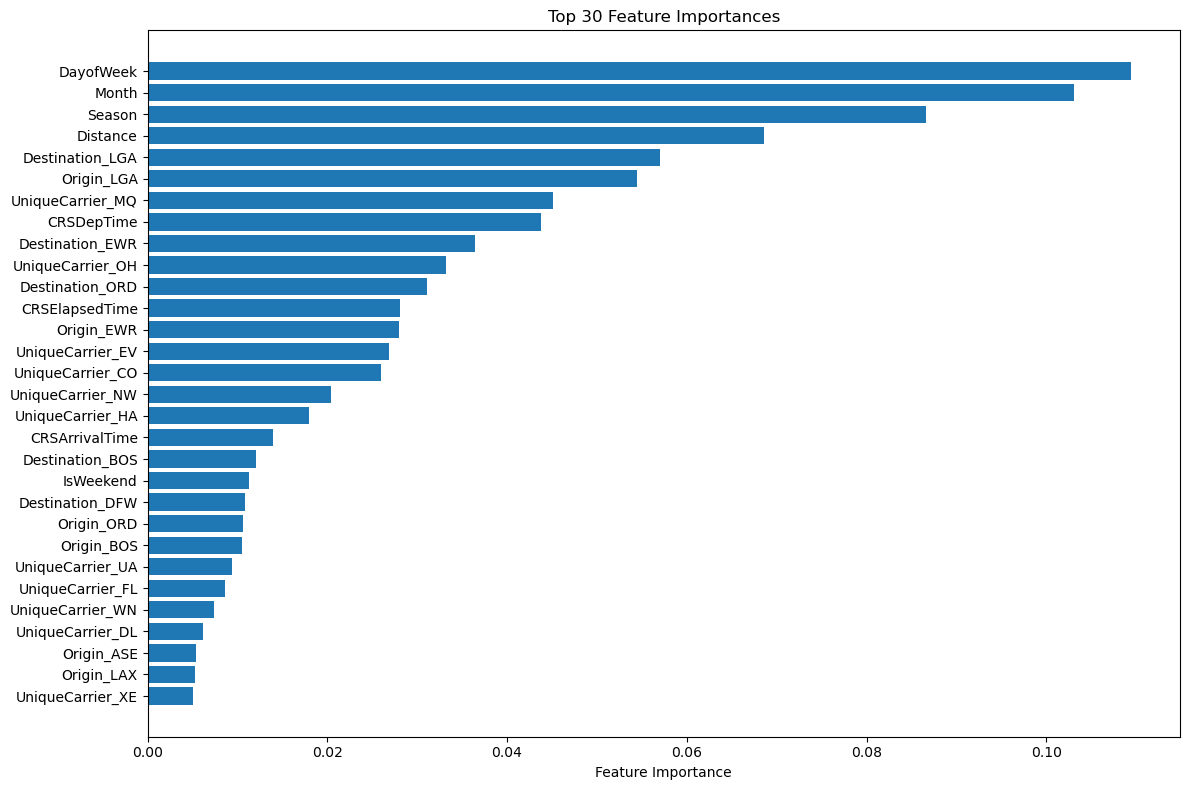

In [32]:
# Extreacting categorial feature names
categorical_feature_names = []
for cat_col in categorical_cols:
    indexer = [stage for stage in preprocessing_model.stages 
                     if isinstance(stage, StringIndexerModel) and stage.getInputCol() == cat_col]
    labels = indexer[0].labels
    one_hot_names = [f"{cat_col}_{label}" for label in labels]
    categorical_feature_names.extend(one_hot_names)

# combine with numerical feature names
all_feature_names = categorical_feature_names + numerical_cols

# Extracting feature importances
importances = gbt_best_model.featureImportances.toArray()

# Create a df for plotting
feature_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Plotting top features
plt.figure(figsize=(12, 8))
plt.barh(feature_df["feature"].head(30), feature_df["importance"].head(30))
plt.xlabel("Feature Importance")
plt.title("Top 30 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Task 7: Model Persistence and Inference

In [33]:
# Paths for saving
output_base_dir = "./model"
best_model_path = os.path.join(output_base_dir, "best_model")
pipeline_path = os.path.join(output_base_dir, "preprocessing_pipeline")

# Creating the base directory if it doesn't exist
os.makedirs(output_base_dir, exist_ok=True)

# Cleaning up previous saves if they exist
try:
    if os.path.exists(best_model_path):
        shutil.rmtree(best_model_path)
        print(f"Removed previous model directory: {best_model_path}")
    if os.path.exists(pipeline_path):
        shutil.rmtree(pipeline_path)
        print(f"Removed previous pipeline directory: {pipeline_path}")
except OSError as e:
    print(f"Error removing directories: {e}")

# Saving the best Gradient Boosted Trees model found via CV
gbt_best_model.write().overwrite().save(best_model_path)
print(f"Best model saved to: {best_model_path}")

# Saving the preprocessing pipeline model
preprocessing_model.write().overwrite().save(pipeline_path)
print(f"Preprocessing pipeline model saved to: {pipeline_path}")

Removed previous model directory: ./model/best_model
Removed previous pipeline directory: ./model/preprocessing_pipeline
Best model saved to: ./model/best_model
Preprocessing pipeline model saved to: ./model/preprocessing_pipeline


### Preparing 2010 test data

Repeating all the preprocessing and cleaning steps as on the training data and the preprocessing model trained on training data.

In [34]:
test_df = spark.read.csv("input/2010.csv", header=True, schema=schema)
test_df.cache()

renamed_columns = [
    "Date", "UniqueCarrier", "FlightNumber", "Origin", "Destination",
    "CRSDepTime", "DepartureTime", "DepartureDelay", "TaxiOut", "WheelsOff",
    "WheelsOn", "TaxiIn", "CRSArrivalTime", "ArrivalTime", "ArrivalDelay",
    "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime",
    "ActualElapsedTime", "AirTime", "Distance", "CarrierDelay",
    "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay",
    "UnusedColumn"
]

test_df = test_df.toDF(*renamed_columns)

test_df = test_df.filter(F.col("Diverted") != 1)
test_df = test_df.drop("Diverted")

test_df = test_df.withColumn("DayofWeek", F.dayofweek("Date")) \
                     .withColumn("Month", F.month("Date"))

test_df = test_df.drop("UnusedColumn", "LateAircraftDelay", "SecurityDelay", "NASDelay", "WeatherDelay", "CarrierDelay", "AirTime", "ActualElapsedTime", "ArrivalDelay", "ArrivalTime", "TaxiIn", "WheelsOn", "CancellationCode")
test_df = test_df.drop("DepartureTime", "DepartureDelay", "TaxiOut", "WheelsOff")

# season
test_df = test_df.withColumn(
    "Season",
    F.when(F.col("Month").isin(12, 1, 2), 0)
    .when(F.col("Month").isin(3, 4, 5), 1)
    .when(F.col("Month").isin(6, 7, 8), 2)
    .when(F.col("Month").isin(9, 10, 11), 3)
    .otherwise(-1)
)

# weekend
test_df = test_df.withColumn("IsWeekend", F.when(F.col("DayofWeek").isin([6, 7]), 1).otherwise(0))

# Transform the 2010 test data
processed_df = preprocessing_model.transform(test_df) 

# Select only the relevant columns for modeling: 'label' and 'features'
test_data_2010 = processed_df.select(label_output_col, feature_output_col)
test_data_2010.cache()

print("Test data transformation complete.")

Test data transformation complete.


### Evaluating Best Model on 2010 Data

In [35]:
# Evaluate on test data
predictions = gbt_best_model.transform(test_data_2010)
auc = binary_evaluator.evaluate(predictions)
accuracy = multi_evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

Accuracy: 0.7653, AUC: 0.6897


In [36]:
# Confusion matrix
df_conf = predictions.withColumn(
    "Group",
    F.when((F.col("label") == 1) & (F.col("prediction") == 1), "TP")
    .when((F.col("label") == 0) & (F.col("prediction") == 1), "FP")
    .when((F.col("label") == 0) & (F.col("prediction") == 0), "TN")
    .when((F.col("label") == 1) & (F.col("prediction") == 0), "FN")
)

# Count each group
confusion_counts = df_conf.groupBy("Group").count()
confusion_counts.show()

+-----+-------+
|Group|  count|
+-----+-------+
|   FP|1455423|
|   TN|4865965|
|   FN|  54516|
|   TP|  58731|
+-----+-------+

